In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets import mnist
from skimage.filters import threshold_mean
from scipy.spatial.distance import hamming
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.
/home/alexander/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexander/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexander/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alexander/anacond

In [2]:
def load_data(dimenssion = 28):
    names  = np.arange(10)
    data   = []
    target = []
    
    for i in range(len(names)):
        name_temp  = 'digits/' + str(names[i]) + '.jpg'
        img        = cv2.imread(name_temp, cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img, (dimenssion, dimenssion), interpolation = cv2.INTER_AREA)
        img_resize = img_to_array(img_resize)
        
        data.append(img_resize)        
        target.append(i)
    
    data   = np.array(data)/255
    target = np.array(target)
    return data, target   

In [3]:
def preprocessing(img):
    w, h = img.shape
    
    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift  = 2*(binary*1)-1 # Boolian to int
    
    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def get_corrupted_input(input):
    corruption_level = 0.3
    corrupted        = np.copy(input)
    inv              = np.random.binomial(n=1, p=corruption_level, size=len(input))
    
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

In [4]:
def hopfield(dimenssion, max_iterations):
    
    # Load data
    x_train, y_train = load_data(dimenssion)
    x_train          = x_train.reshape(x_train.shape[0], dimenssion,dimenssion)
    nb_patterns      = 10
    
    data = []
    for i in range(nb_patterns):        
        xi = x_train[y_train==i]
        data.append(xi[0])

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    data = np.array(data)

    # Train the network
    print('Training the network...')
    W = np.zeros((dimenssion * dimenssion, dimenssion * dimenssion))

    for i in tqdm(range(nb_patterns)):
        t  = data[i]
        W += np.outer(t, t)
    
    diagW = np.diag(np.diag(W))
    W     = W - diagW
    
    print('Start to data testing preprocessing...')
    test = []
    for d in data:
        aux = get_corrupted_input(d)
        test.append(aux)

    print('Start testing...')
    val_hamming = 0
    for idx in range(len(test)):
        # Recover the original patterns
        A = test[idx].copy()
        
        for _ in range(max_iterations):
            for i in range(dimenssion * dimenssion):
                if A[i] != data[idx][i]:
                    A[i] = 1.0 if np.dot(W[i], A) > 0 else -1.0
        
        # Show corrupted and recovered patterns
        val_hamming += hamming(data[idx], A)
                
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].matshow(data[idx].reshape(dimenssion, dimenssion), cmap='gray')
        ax[0].set_title('Original pattern')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        
        ax[1].matshow(test[idx].reshape(dimenssion, dimenssion), cmap='gray')
        ax[1].set_title('Corrupted pattern')
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].matshow(A.reshape(dimenssion, dimenssion), cmap='gray')
        ax[2].set_title('Recovered pattern')
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        
    plt.show()
    return val_hamming / len(test)        

# Testing with 784 neurons

100%|██████████| 10/10 [00:00<00:00, 325.67it/s]

Start to data preprocessing...
Training the network...
Start to data testing preprocessing...
Start testing...


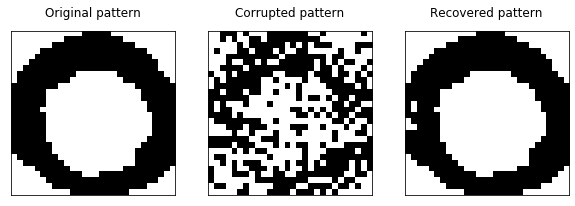

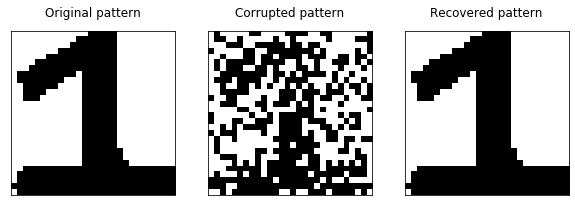

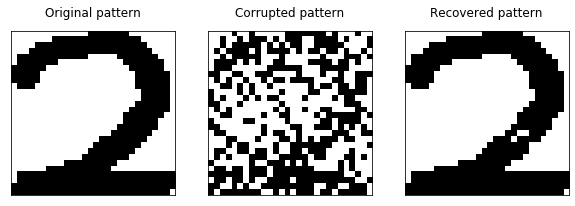

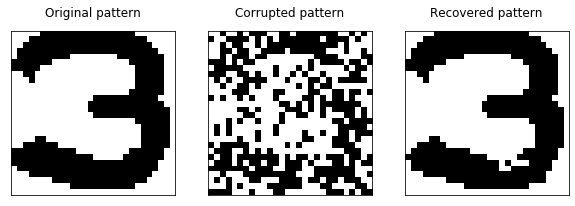

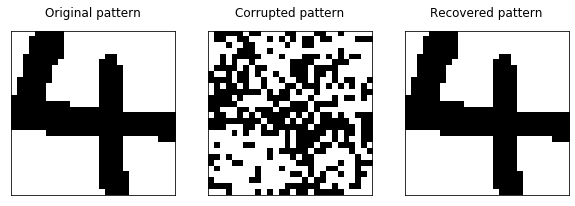

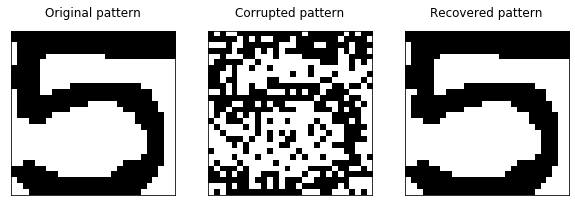

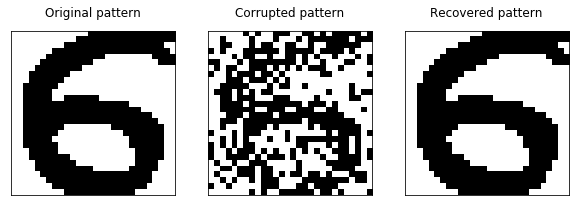

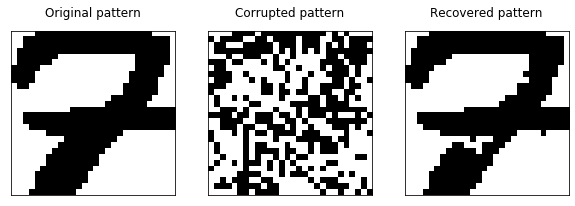

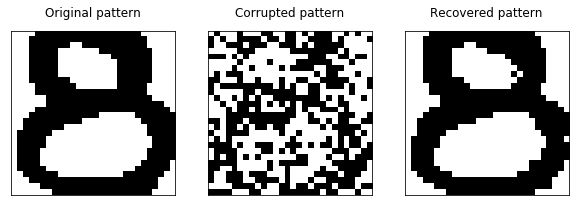

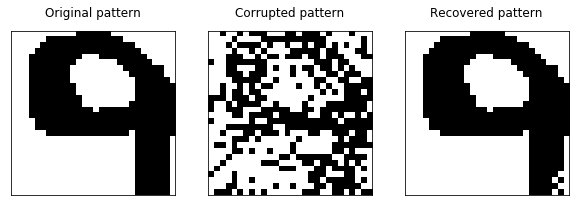

In [5]:
dimenssion     = 28
max_iterations = 10    
dist_hamming   = hopfield(dimenssion, max_iterations)

### Distance hamming of 784 neurons

In [6]:
print('Mean Hamming Distance: ', dist_hamming)

Mean Hamming Distance:  0.00586734693877551


# Testing with 225 neurons

100%|██████████| 10/10 [00:00<00:00, 4543.72it/s]

Start to data preprocessing...
Training the network...
Start to data testing preprocessing...
Start testing...


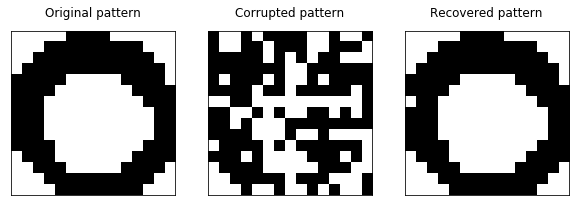

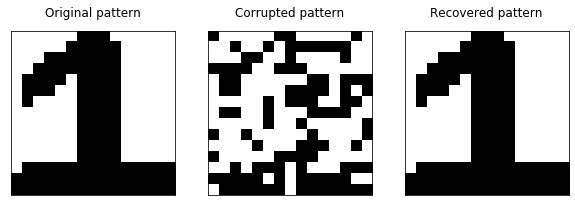

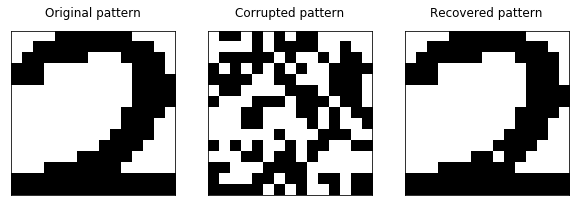

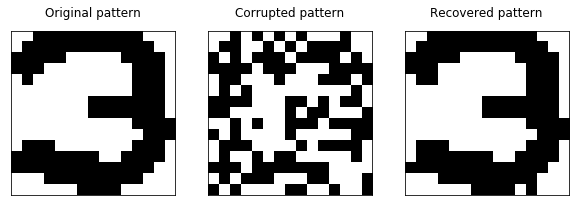

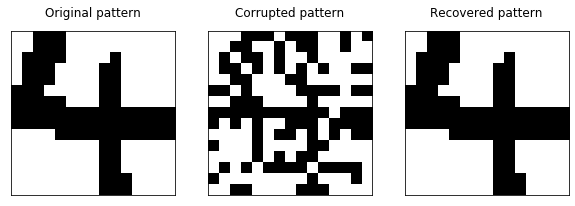

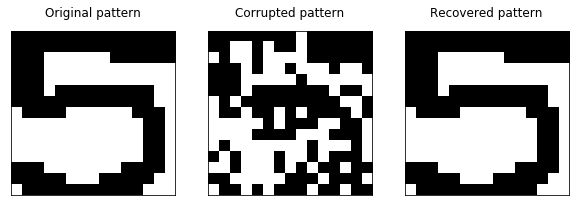

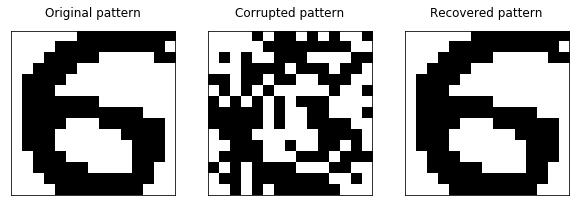

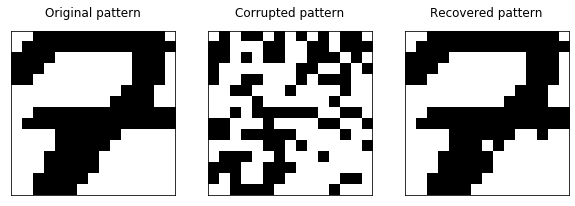

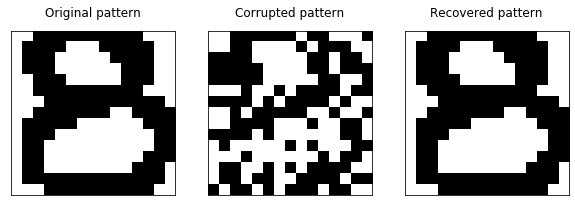

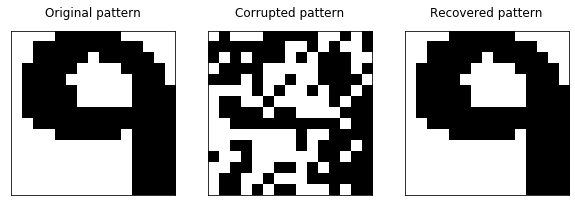

In [7]:
dimenssion     = 15
max_iterations = 10    
dist_hamming   = hopfield(dimenssion, max_iterations)

### Distance hamming of 225 neurons

In [8]:
print('Mean Hamming Distance: ', dist_hamming)

Mean Hamming Distance:  0.004


# Testing with 64 neurons

100%|██████████| 10/10 [00:00<00:00, 20982.01it/s]

Start to data preprocessing...
Training the network...
Start to data testing preprocessing...
Start testing...


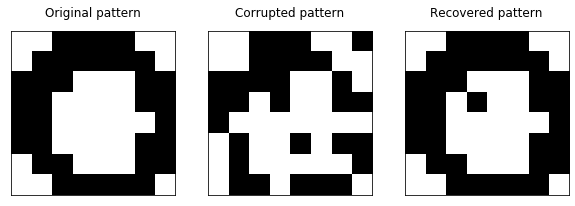

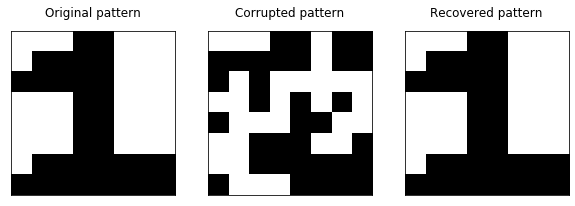

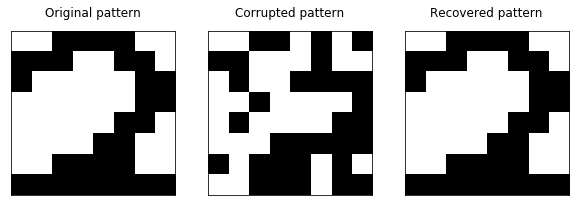

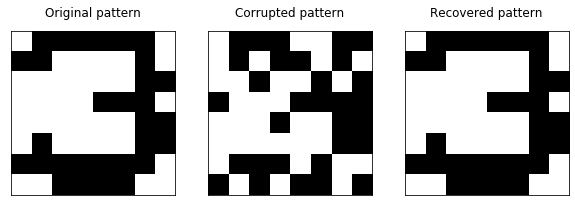

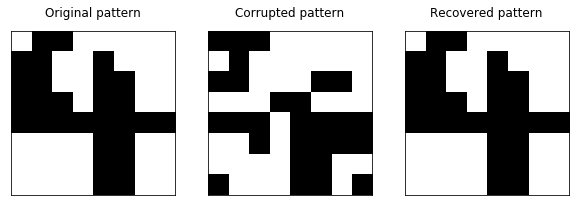

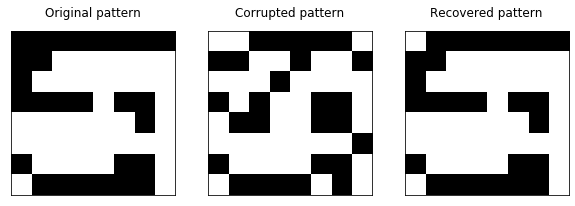

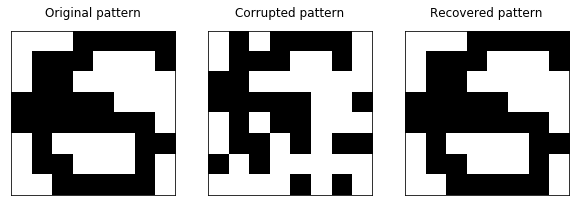

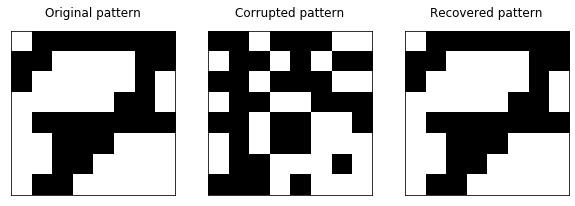

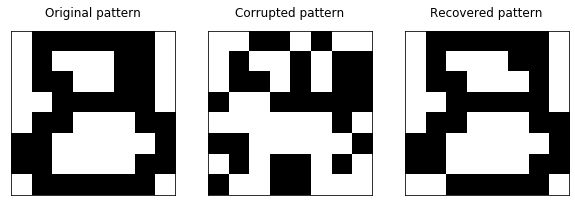

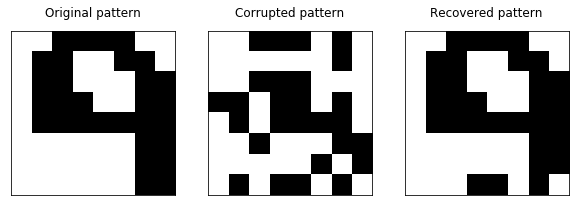

In [9]:
dimenssion     = 8
max_iterations = 10    
dist_hamming   = hopfield(dimenssion, max_iterations)

### Distance hamming of 225 neurons

In [10]:
print('Mean Hamming Distance: ', dist_hamming)

Mean Hamming Distance:  0.0109375
